In [55]:
%precision 6
%matplotlib inline
import pandas as pd
from pandas import Series
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as si
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spla
# the following allows us to plot triangles indicating convergence order
from mpltools import annotation
# as we're in 2D we will be doing some 3D plotting
from mpl_toolkits.mplot3d import Axes3D
# and using some colormaps
from matplotlib import cm
from pprint import pprint

# some default font sizes for plots
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Dejavu Sans']

## Q1: STEADY-STATE ADVECTION-DIFFUSION WITH FEM

- This question involbes solving the steady-state advevtion-diffusion equation below using the Finite Element Method(FEM) in 1D.

$$\kappa\frac{\partial^2 u}{\partial x^2} + U\frac{\partial u}{\partial x} = 0, $$

- The method implemented here is that of L12, which involves looping over the elements.

In [228]:
#problem parameters
kappa = 0.005
L = 1
Pe = 10
U = Pe * kappa / L
CE = 1
CO = 0

#function for the RHS of the problem
def f(x):
    return 0

#functio to define the exact solution to the problem.
def u_exact(x):
    return CE * (np.exp(Pe * x / L) - 1) / (np.exp(Pe) - 1)


# to do this we need our Simpson's quadrature codes
def simpsons_rule(a, b, function, number_intervals=10):
    """ Function to evaluate Simpson's rule. 
    
    Note that this implementation takes the function as an argument, 
    and evaluates this at the midpoint of subintervals in addition to the 
    end point. Hence additional information is generated and used through 
    additional function evaluations. 
    
    This is different to the function/implementation available with SciPy  
    where discrete data only is passed to the function. 
    
    Bear this in mind when comparing results - there will be a factor of two
    in the definition of "n" we need to be careful about!
    
    Also note that this version of the function performs redundant function 
    evaluations - see the **composite** implementation below.
    """

    interval_size = (b - a)/number_intervals

    assert interval_size > 0
    assert type(number_intervals) == int

    I_S = 0.0

    # Loop to valuate Simpson's formula over each interval 
    for i in range(number_intervals):
        # Find a, c, and b
        this_bin_start = a + interval_size * (i)
        this_bin_mid = this_bin_start + interval_size/2
        this_bin_end = this_bin_start + interval_size
        # Calculate the rule and add to running total.
        I_S += (interval_size/6) * (function(this_bin_start) +
                                  4 * function(this_bin_mid) + function(this_bin_end))

    # Return our running total result
    return I_S

def simpsons_composite_rule(a, b, function, number_intervals=10):
    """Function to evaluate the composite Simpson's rule only using
    function evaluations at (number_intervals + 1) points.
    
    This implementation requires that the number of subintervals (number_intervals) be even
    """
    assert number_intervals % 2 == 0, "number_intervals is not even"

    interval_size = (b - a) / number_intervals
    # start with the two end member values
    I_cS2 = function(a) + function(b)

    # add in those terms with a coefficient of 4
    for i in range(1, number_intervals, 2):
        I_cS2 += 4 * function(a + i * interval_size)

    # and those terms with a coefficient of 2
    for i in range(2, number_intervals-1, 2):
        I_cS2 += 2 * function(a + i * interval_size)

    return I_cS2 * (interval_size / 3.0)

In [229]:
def generate_1D_CG_mesh(Lx, N_elements_CG, mesh_option=0):
    """ Function to generate a mesh given the domain size Lx
    (we assume the left hand entry is always at zero).
    
    Use N_elements_CG number of element.
    
    mesh_option==0 corresponds to a uniform mesh - only option implemented so far.
    
    Returns: the node locations x_node and the mesh spacing dx
    """
    if(mesh_option==0):
        x_nodes = np.linspace(0, Lx ,N_elements_CG+1)
    else:
        raise Exception('mesh_option != 0 not implemented yet')
    # given the mesh (somehow) compute an array of element sizes
    dx = np.diff(x_nodes)
    return x_nodes, dx

def connectivity(N_loc, N_elements_CG):
    """ Generate the connectivity matrix of dimension N_loc * N_elements_CG.
    
    Row corresponds to the local node number, column to the element number,
    the entry of the matrix is then a global node number.
    
    Returns: the connectivity matrix
    """
    connectivity_matrix = np.zeros((N_loc, N_elements_CG), dtype=int)
    if(N_loc==2):
        for element in range (N_elements_CG):
            connectivity_matrix[0, element] = element
            connectivity_matrix[1, element] = element + 1
    else:
        raise Exception('Only linear element (N_loc=2) implemented.')
    return connectivity_matrix

def shape(N_loc, N_gi):
    """ Define reference shape functions - their values at N_gi quadrature points.
    
    Only implemented for N_loc = 2, i.e. two nodes per element - linear basis functions.
    """ 
    assert(N_loc==2)
    phi = np.zeros( (N_loc, N_gi) )
    if(N_gi==2):
        phi[0,0] = 1.0 
        phi[0,1] = 0.0 
        phi[1,0] = 0.0 
        phi[1,1] = 1.0
    elif(N_gi==3):
        phi[0,0] = 1.0 
        phi[0,1] = 0.5 
        phi[0,2] = 0.0 
        phi[1,0] = 0.0 
        phi[1,1] = 0.5 
        phi[1,2] = 1.0        
    else:
        raise Exception('N_gi value not implemented.')
    return phi

def shape_derivatives(element, dx, N_loc, N_gi):
    """ Define derivatives of shape functions - their values at N_gi quadrature points
    over the reference element.
    
    Only implemented for N_loc = 2, i.e. two nodes per element - 
    linear basis functions.
    """   
    assert(N_loc==2)
    phi_x = np.zeros( (N_loc, N_gi) )
    # the derivatives of our linear basis functions over the reference element
    if(N_gi==2):
        phi_x[0,0] = -1. / 2.
        phi_x[0,1] =  phi_x[0,0] 
        phi_x[1,0] = -phi_x[0,0]  
        phi_x[1,1] =  phi_x[1,0]
    elif(N_gi==3):
        phi_x[0,0] = -1. / 2.
        phi_x[0,1] = phi_x[0,0] 
        phi_x[0,2] = phi_x[0,0] 
        phi_x[1,0] = -phi_x[0,0] 
        phi_x[1,1] = phi_x[1,0] 
        phi_x[1,2] = phi_x[1,0]            
    else:
        raise Exception('N_gi value not implemented.')
    # Jacobian contribution as seen/explained above due to the use of the chain rule
    phi_x = phi_x * (2. / dx[element]) 
    return phi_x

def quadrature(N_gi):
    """ Define quadrature rule on N_gi quadrature points.
    """    
    weight = np.zeros(N_gi)
    if(N_gi==2):  # Trapezoidal rule in 1D
        weight[0] = 0.5 
        weight[1] = 0.5
    elif(N_gi==3): # Simpson's rule in 1D
        weight[0] = 1. / 6. 
        weight[1] = 2. / 3. 
        weight[2] = 1. / 6.
    else:
        raise Exception('N_gi value not implemented.')
    return weight
   



In [230]:
def assembly_local(M, K1, K2, element, connectivity_matrix, N_loc, N_gi, weight, phi, phi_x, dx):
    """ Perform local assembly by looping over products of the local node numbers 
    (i.e. products of local basis functions), computing the required integrals, and 
    adding contributions to the correct locations of the global discretisation matrices.
    """
    for i_loc in range(N_loc):
        i_global = connectivity_matrix[i_loc, element]
        for j_loc in range(N_loc):
            j_global = connectivity_matrix[j_loc, element]
            # perform the quadrature - over one element with one "quadrature interval"
            # "weight" is the quadrature weight, e.g. 1/6, 4/6, 1/6 for Simpson's rule
            # and we need to remember to include the Jacobian determinant
            phix_phi = 0.
            phi_phi = 0.
            phix_phix = 0.
            for gi in range(N_gi):
                phi_phi += weight[gi] * phi[i_loc, gi] * phi[j_loc, gi] * 0.5*dx[element] 
                phix_phi += weight[gi] * phi[i_loc, gi] * phi_x[j_loc, gi] * 0.5*dx[element] # included for advection 
                phix_phix += weight[gi] * phi_x[i_loc, gi] * phi_x[j_loc, gi] * 0.5*dx[element]
            M[i_global, j_global] = M[i_global, j_global] + phi_phi # mass matrix
            K1[i_global, j_global] = K1[i_global, j_global] + phix_phix # diffusion matrix
            K2[i_global, j_global] = K2[i_global, j_global] + phix_phi # advection matrix
    

In [231]:
def assembly_global(M, K1, K2, N_elements_CG, connectivity_matrix, N_loc, N_gi, weight, phi, dx):
    """ Perform global assembly by looping over elements.
    """
    # loop over all elements
    for element in range(N_elements_CG):
        # compute the derivatives of the basis function on this element
        phi_x = shape_derivatives(element, dx, N_loc, N_gi)
        assembly_local(M, K1, K2, element, connectivity_matrix, N_loc, N_gi, weight, phi, phi_x, dx)

In [232]:
def apply_bcs(A, b, lbc, rbc, bc_option=0):
    """Apply BCs using a big spring method.
    
    bc_option==0 Homogeneous Neumann
    bc_option==1 Dirichlet
    """
    if(bc_option==0):
        return
    elif(bc_option==1):
        big_spring = 1.0e10
        A[0,0] = big_spring            
        b[0]   = big_spring * lbc
        A[-1,-1] = big_spring            
        b[-1]   = big_spring * rbc       
    else:
        raise Exception('bc option not implemented')

In [233]:
def initial_condition(x, IC_option=0):
    """ Function to define an initial condition on our mesh.
    """
    if(IC_option==0):
        return CE * (np.exp(Pe * x / L) - 1) / (np.exp(Pe) - 1)
    else:
        raise Exception('Option not implemented.')   

In [234]:
# domain size
Lx = 1.

# mesh data
N_nodes_CG = 12
N_elements_CG = N_nodes_CG - 1

# define some numerical parameters
N_loc = 2
N_gi = 3

# generate mesh
x_nodes, dx = generate_1D_CG_mesh(Lx, N_elements_CG)
connectivity_matrix = connectivity(N_loc, N_elements_CG)

# time stepping
#dt = 0.001
#t = 0 
#t_end = dt*1000
#theta = 0.
u_ic = initial_condition(x_nodes)


# set-up things we need for our discretisation
# the basis functions defined on our reference element
phi = shape(N_loc, N_gi)

# quadrature weights
weight = quadrature(N_gi)

# allocate space to store our discretisation matrices
M = np.zeros((N_nodes_CG, N_nodes_CG))
K1 = np.zeros((N_nodes_CG, N_nodes_CG))
K2 = np.zeros((N_nodes_CG, N_nodes_CG))

# assemble the individual discretisation matrices
assembly_global(M, K1, K2, N_elements_CG, connectivity_matrix, N_loc, N_gi, weight, phi, dx)

# and combine them into our final matrix system
A =  U * K2 + kappa * K1 + M
RHS_matrix = M - kappa*K1 - U *K2
u_old = np.copy(u_ic)
b = RHS_matrix @ u_old.T 
apply_bcs(A, b, CO, CE, bc_option=1)
u = sl.solve(A, b)
#u_old = np.copy(u)


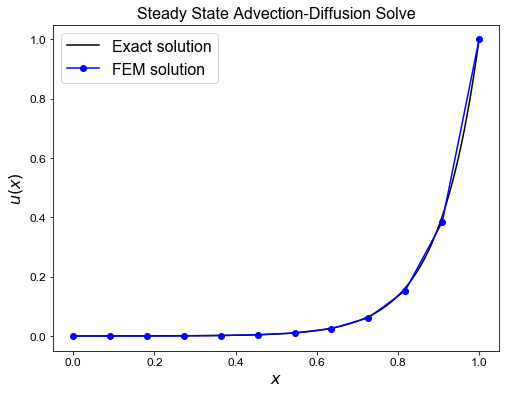

In [235]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$u(x)$', fontsize=16)
ax1.set_title('Steady State Advection-Diffusion Solve', fontsize=16)

x_fine = np.linspace(0, 1, 1000)
ax1.plot(x_fine, u_exact(x_fine), 'k-', label='Exact solution')
ax1.plot(x_nodes, u, 'bo-', label='FEM solution')
ax1.legend(loc='best', fontsize=16);

## Comments

1. The FEM has been implemented to solve the advection-diffusion steady state 1D problem.



2. The FEM solution appears to be acceptable qualitatively. However, the FEM method couldn't produce excellent qualitative results where the elements are modelling curved regions of the exact solution. This could be connected to the fact that we're using linear equations to create the weak form of the exact equation.

##  Implementing convergence 

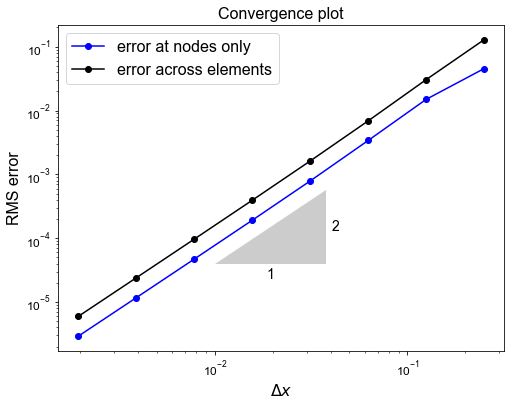

In [65]:
Ns = [2**p for p in range(2, 10)]
errors = np.zeros((2,len(Ns)))

def hat_function(i, x_nodes):
    """ Linear continuous basis function at node i.
    Returns a function for later use in quadrature rules.
    """
    assert(i>=0 and i<=len(x_nodes)-1)
    dx = np.diff(x_nodes)
    if i==0:
        hat = lambda x: np.select([ x<=x_nodes[i+1] ], [ (x_nodes[i+1] - x)/dx[i] ] ,0.0)
    elif i==len(x_nodes)-1:
        hat = lambda x: np.select([ x>=x_nodes[i-1] ], [ (x - x_nodes[i-1])/dx[i-1] ] ,0.0)
    else:
        hat = lambda x: np.select(
                [ np.all([[x>=x_nodes[i-1]],[x<=x_nodes[i]]], axis=0)[0],  
                  np.all([[x>=x_nodes[i]],[x<=x_nodes[i+1]]], axis=0)[0]] ,
                [ (x-x_nodes[i-1])/dx[i-1], (x_nodes[i+1]-x)/dx[i] ] ,0.0)
    return hat

def pwlinear(x_nodes, y_nodes, x):
    """Function to return f_h(x) at locations given in x, 
    with top hat functions on a mesh given by x_nodes, and
    corresponding weights given in y_nodes.
    """
    val = np.zeros_like(x)
    # loop over x values
    for i in range(len(x)):
        # which mesh node is directly to the left of x[i] ?
        node = np.where( x[i] >= x_nodes )[0][-1]
        # because of the greather than or equals above, deal with problem of hitting last node
        node = np.minimum(len(x_nodes)-2,node)
        # add together the contributions from the two hat functions at this x location
        phi_node = hat_function(node, x_nodes)
        phi_node_plus_1 = hat_function(node+1, x_nodes)
        val[i] = y_nodes[node]*phi_node(x[i]) + y_nodes[node+1]*phi_node_plus_1(x[i])
    return val

for i, N in enumerate(Ns):
    Lx = 1.
    #kappa = 0.01

    # mesh data
    N_nodes_CG = N
    N_elements_CG = N_nodes_CG - 1

    # define some numerical parameters
    N_loc = 2
    N_gi = 3

    # generate mesh
    x_nodes, dx = generate_1D_CG_mesh(Lx, N_elements_CG)
    connectivity_matrix = connectivity(N_loc, N_elements_CG)

    # time stepping
    #dt = 0.001
    #t = 0 
    #t_end = dt*1000
    #theta = 0.
    u_ic = initial_condition(x_nodes)

    #print('r parameter: ', kappa*dt/(np.min(dx)**2))

    # set-up things we need for our discretisation
    # the basis functions defined on our reference element
    phi = shape(N_loc, N_gi)

    # quadrature weights
    weight = quadrature(N_gi)

    # allocate space to store our discretisation matrices
    M = np.zeros((N_nodes_CG, N_nodes_CG))
    K1 = np.zeros((N_nodes_CG, N_nodes_CG))
    K2 = np.zeros((N_nodes_CG, N_nodes_CG))

    # assemble the individual discretisation matrices
    assembly_global(M, K1, K2, N_elements_CG, connectivity_matrix, N_loc, N_gi, weight, phi, dx)

    # and combine them into our final matrix system
    A =  U * K2 + kappa * K1 + M
    RHS_matrix = M - kappa*K1 - U *K2
    u_old = np.copy(u_ic)
    b = RHS_matrix @ u_old.T 
    apply_bcs(A, b, CO, CE, bc_option=1) # homogenous drichlet boundary is selected.
    u = sl.solve(A, b)
    #print(u)
    
    # RMS error of the nodal errors - cf. comments in main lecture text
    errors[0,i] = sl.norm(u - u_exact(x_nodes)) / np.sqrt(len(u)) 
    # now let's do the RMS on a fine mesh to approximate the L2 norm
    x_fine = np.linspace(x_nodes[0],x_nodes[-1],1000)
    errors[1,i] = sl.norm(pwlinear(x_nodes, u, x_fine) - u_exact(x_fine)) \
                        / np.sqrt(len(x_fine))
    
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$\Delta x$', fontsize=16)
ax1.set_ylabel('RMS error', fontsize=16)
ax1.set_title('Convergence plot', fontsize=16)
ax1.loglog(1./np.array(Ns), errors[0,:], 'bo-', label='error at nodes only')
ax1.loglog(1./np.array(Ns), errors[1,:], 'ko-', label='error across elements')
ax1.legend(loc='best', fontsize=16)
annotation.slope_marker((1e-2, 4e-5), (2, 1), ax=ax1,
                        size_frac=0.25, pad_frac=0.05, text_kwargs = dict(fontsize = 14))

## Comments

1. A convergence plot, using the exact analytical solution, has been done to confirm the accuracy of the FEM solver.


2. An order of convergence : 2, has been confirmed from the convergence plot, indicating our solver is second order accurate in terms of both at the nodes and across the elements. This is the expected order of convergence for both cases, since our solver is looping across the elements and note the nodes, as in L11.

3. The order of convergence here is 2, because linear elements are used to form our weak form. If quadratic elements were used, the order would be 3. Therefore, using the $L^2$ norm formular, order of convergence for FEM can be stated as:


$$e_{L^2} = Ch^{p+1}$$

where p is the order of element

## Comparing errors with a finite difference solver

The sum of errors for the finite difference solver across elements is 0.37113
The sum of erros for the finite element solver across elements is 0.16827


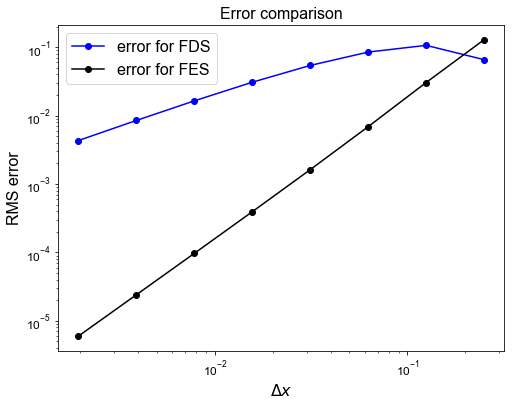

In [84]:
Ns = [2**p for p in range(2, 10)]
errors = np.zeros((2,len(Ns)))

def BVP_AD_central(L, U, kappa, CE, N):
    """ function to assemble and solve the AD BVP problem
    using central differences for both adv and diff.
    
    Returns the mesh x and the solution C
    """
    dx = L/N
    x = np.linspace(-dx / 2, dx / 2 + L, N + 2)
    A = np.zeros((N + 2, N + 2))
    b = np.zeros((N + 2))
    # interior points
    r_diff = kappa / dx**2
    r_adv = 0.5 * U / dx
    for i in range(1, N + 1):
        A[i, i - 1] = r_diff + r_adv
        A[i, i] = -2 * r_diff
        A[i, i + 1] = r_diff - r_adv
        b[i] = 0
    # BC1
    A[0, 0] = 0.5
    A[0, 1] = 0.5
    b[0] = 0
    # BC2
    A[N + 1, N] = 0.5
    A[N + 1, N + 1] = 0.5
    b[N + 1] = CE  # BC2
    # invert matrix
    #print(len(x))
    C = np.linalg.solve(A, b)
    #print(len(C))
    return x, C

for i, N in enumerate(Ns):
    Lx = 1.
    #kappa = 0.01

    # mesh data
    N_nodes_CG = N
    N_elements_CG = N_nodes_CG - 1

    # define some numerical parameters
    N_loc = 2
    N_gi = 3

    # generate mesh
    x_nodes, dx = generate_1D_CG_mesh(Lx, N_elements_CG)
    connectivity_matrix = connectivity(N_loc, N_elements_CG)

    # time stepping
    dt = 0.001
    t = 0 
    t_end = dt*1000
    theta = 0.
    u_ic = initial_condition(x_nodes)

    #print('r parameter: ', kappa*dt/(np.min(dx)**2))

    # set-up things we need for our discretisation
    # the basis functions defined on our reference element
    phi = shape(N_loc, N_gi)

    # quadrature weights
    weight = quadrature(N_gi)

    # allocate space to store our discretisation matrices
    M = np.zeros((N_nodes_CG, N_nodes_CG))
    K1 = np.zeros((N_nodes_CG, N_nodes_CG))
    K2 = np.zeros((N_nodes_CG, N_nodes_CG))

    # assemble the individual discretisation matrices
    assembly_global(M, K1, K2, N_elements_CG, connectivity_matrix, N_loc, N_gi, weight, phi, dx)

    # and combine them into our final matrix system
    A =  U * K2 + kappa * K1 + M
    RHS_matrix = M - kappa*K1 - U *K2
    u_old = np.copy(u_ic)
    b = RHS_matrix @ u_old.T 
    apply_bcs(A, b, CO, CE, bc_option=1)
    u = sl.solve(A, b)
    #print(u)
    
    # solution from finite difference solver using the central difference method
    x, u1 = BVP_AD_central(L, U, kappa, CE, N)
    # RMS error of the nodal errors - cf. comments in main lecture text
    #errors[0,i] = sl.norm(u - u_exact(x_nodes)) / np.sqrt(len(u)) 
    
    #errors[1,i] = sl.norm(u1 - u_exact(x_nodes)) / np.sqrt(len(u))
    x_fine = np.linspace(x_nodes[0],x_nodes[-1],1000)
    x_fine1 = np.linspace(x[1],x[-2],1000)
    # compute errors for finite difference solver, ensuring the ghost nodes are skipped.
    errors[0,i] = sl.norm(pwlinear(x[1:-1], u1, x_fine1) - u_exact(x_fine1)) \
                        / np.sqrt(len(x_fine1))
    # compute errors for finite element solver.
    errors[1,i] = sl.norm(pwlinear(x_nodes, u, x_fine) - u_exact(x_fine)) \
                       / np.sqrt(len(x_fine))
    
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$\Delta x$', fontsize=16)
ax1.set_ylabel('RMS error', fontsize=16)
ax1.set_title('Error comparison', fontsize=16)
ax1.loglog(1./np.array(Ns), errors[0,:], 'bo-', label='error for FDS') # plot for finite difference solver
ax1.loglog(1./np.array(Ns), errors[1,:], 'ko-', label='error for FES') # plot for finite element solver
ax1.legend(loc='best', fontsize=16)
print("The sum of errors for the finite difference solver across elements is {0:.5f}".format(np.sum(errors[0,:])))
print('The sum of erros for the finite element solver across elements is {0:.5f}'.format(np.sum(errors[1,:])))

## Comments

1. The errors for the finite diference and finite element solvers were compared. The plot shows errors from the finite element solver are lower than those of the finite difference solver. 


2. The sum of errors of both solvers was printed for comparison, which shows a better job done by the finite element solver compared to the finite difference solver.

## Q2: TIME-DEPENDENT ADVECTION-DIFFUSION WITH FEM

- This question involbes solving the steady-state advevtion-diffusion equation below using the Finite Element Method(FEM) in 1D.

$$\kappa\frac{\partial^2 u}{\partial x^2} + U\frac{\partial u}{\partial x} = \frac{\partial u}{\partial t} , $$

- The method implemented here is that of L12, which involves looping over the elements.

In [126]:
def f(x):
    return 0

def u_exact(x,x0,t,kappa,U):
    return np.exp( -((x-x0) - U*t)**2 / (4.*kappa*t)) / np.sqrt(4. * np.pi * kappa * t)

def generate_1D_CG_mesh(Lx, N_elements_CG, mesh_option=0):
    """ Function to generate a mesh given the domain size Lx
    (we assume the left hand entry is always at zero).
    
    Use N_elements_CG number of element.
    
    mesh_option==0 corresponds to a uniform mesh - only option implemented so far.
    
    Returns: the node locations x_node and the mesh spacing dx
    """
    if(mesh_option==0):
        x_nodes = np.linspace(0, Lx ,N_elements_CG+1)
    else:
        raise Exception('mesh_option != 0 not implemented yet')
    # given the mesh (somehow) compute an array of element sizes
    dx = np.diff(x_nodes)
    return x_nodes, dx

def connectivity(N_loc, N_elements_CG):
    """ Generate the connectivity matrix of dimension N_loc * N_elements_CG.
    
    Row corresponds to the local node number, column to the element number,
    the entry of the matrix is then a global node number.
    
    Returns: the connectivity matrix
    """
    connectivity_matrix = np.zeros((N_loc, N_elements_CG), dtype=int)
    if(N_loc==2):
        for element in range (N_elements_CG):
            connectivity_matrix[0, element] = element
            connectivity_matrix[1, element] = element + 1
    else:
        raise Exception('Only linear element (N_loc=2) implemented.')
    return connectivity_matrix

def shape(N_loc, N_gi):
    """ Define reference shape functions - their values at N_gi quadrature points.
    
    Only implemented for N_loc = 2, i.e. two nodes per element - linear basis functions.
    """ 
    assert(N_loc==2)
    phi = np.zeros( (N_loc, N_gi) )
    if(N_gi==2):
        phi[0,0] = 1.0 
        phi[0,1] = 0.0 
        phi[1,0] = 0.0 
        phi[1,1] = 1.0
    elif(N_gi==3):
        phi[0,0] = 1.0 
        phi[0,1] = 0.5 
        phi[0,2] = 0.0 
        phi[1,0] = 0.0 
        phi[1,1] = 0.5 
        phi[1,2] = 1.0        
    else:
        raise Exception('N_gi value not implemented.')
    return phi

def shape_derivatives(element, dx, N_loc, N_gi):
    """ Define derivatives of shape functions - their values at N_gi quadrature points
    over the reference element.
    
    Only implemented for N_loc = 2, i.e. two nodes per element - 
    linear basis functions.
    """   
    assert(N_loc==2)
    phi_x = np.zeros( (N_loc, N_gi) )
    # the derivatives of our linear basis functions over the reference element
    if(N_gi==2):
        phi_x[0,0] = -1. / 2.
        phi_x[0,1] =  phi_x[0,0] 
        phi_x[1,0] = -phi_x[0,0]  
        phi_x[1,1] =  phi_x[1,0]
    elif(N_gi==3):
        phi_x[0,0] = -1. / 2.
        phi_x[0,1] = phi_x[0,0] 
        phi_x[0,2] = phi_x[0,0] 
        phi_x[1,0] = -phi_x[0,0] 
        phi_x[1,1] = phi_x[1,0] 
        phi_x[1,2] = phi_x[1,0]            
    else:
        raise Exception('N_gi value not implemented.')
    # Jacobian contribution as seen/explained above due to the use of the chain rule
    phi_x = phi_x * (2. / dx[element]) 
    return phi_x

In [127]:
def assembly_local(M, K1, K2, element, connectivity_matrix, N_loc, N_gi, weight, phi, phi_x, dx):
    """ Perform local assembly by looping over products of the local node numbers 
    (i.e. products of local basis functions), computing the required integrals, and 
    adding contributions to the correct locations of the global discretisation matrices.
    """
    for i_loc in range(N_loc):
        i_global = connectivity_matrix[i_loc, element]
        for j_loc in range(N_loc):
            j_global = connectivity_matrix[j_loc, element]
            # perform the quadrature - over one element with one "quadrature interval"
            # "weight" is the quadrature weight, e.g. 1/6, 4/6, 1/6 for Simpson's rule
            # and we need to remember to include the Jacobian determinant
            phix_phi = 0.
            phi_phi = 0.
            phix_phix = 0.
            for gi in range(N_gi):
                phi_phi += weight[gi] * phi[i_loc, gi] * phi[j_loc, gi] * 0.5*dx[element] 
                phix_phi += weight[gi] * phi[i_loc, gi] * phi_x[j_loc, gi] * 0.5*dx[element] # dx here is the Jacobian determinant 
                phix_phix += weight[gi] * phi_x[i_loc, gi] * phi_x[j_loc, gi] * 0.5*dx[element]
            M[i_global, j_global] = M[i_global, j_global] + phi_phi 
            K1[i_global, j_global] = K1[i_global, j_global] + phix_phix  
            K2[i_global, j_global] = K2[i_global, j_global] + phix_phi   

In [128]:
def assembly_global(M, K1, K2, N_elements_CG, connectivity_matrix, N_loc, N_gi, weight, phi, dx):
    """ Perform global assembly by looping over elements.
    """
    # loop over all elements
    for element in range(N_elements_CG):
        # compute the derivatives of the basis function on this element
        phi_x = shape_derivatives(element, dx, N_loc, N_gi)
        assembly_local(M, K1, K2, element, connectivity_matrix, N_loc, N_gi, weight, phi, phi_x, dx)

In [129]:
def apply_bcs(A, b, lbc, rbc, bc_option=0):
    """Apply BCs using a big spring method.
    
    bc_option==0 Homogeneous Neumann
    bc_option==1 Dirichlet
    """
    if(bc_option==0):
        return
    elif(bc_option==1):
        big_spring = 1.0e10
        A[0,0] = big_spring            
        b[0]   = big_spring * lbc
        A[-1,-1] = big_spring            
        b[-1]   = big_spring * rbc       
    else:
        raise Exception('bc option not implemented')

In [130]:
def initial_condition(x,x0,t,kappa,U, IC_option=0):
    """ Function to define an initial condition on our mesh.
    """
    if(IC_option==0):
        val = np.exp( -((x-x0) - U*t)**2 / (4.*kappa*t)) / np.sqrt(4. * np.pi * kappa * t)
        return val

    else:
        raise Exception('Option not implemented.') 

In [209]:
# problem parameters and time stepping
U = 1
kappa = 1./100.
L = 3
dt = 0.001
t_start = 0.05
t = 0.05
t_end = t_start + 1
theta = [0, 0.5, 1]
x0 = 0.5

# mesh data
N_nodes_CG = 250
N_elements_CG = N_nodes_CG - 1

# define some numerical parameters
N_loc = 2
N_gi = 3

# generate mesh
x_nodes, dx = generate_1D_CG_mesh(L, N_elements_CG)
connectivity_matrix = connectivity(N_loc, N_elements_CG)

# time stepping
u_ic = initial_condition(x_nodes,x0,t_start,kappa,U, IC_option=0)
u_ic_f = initial_condition(x_nodes,x0,t_end,kappa,U, IC_option=0)
print('r parameter: ', kappa*dt/(np.min(dx)**2))
print('Pe_c: ', U*np.min(dx)/kappa)
print('CFL: ', U*dt/np.min(dx))

# set-up things we need for our discretisation
# the basis functions defined on our reference element
phi = shape(N_loc, N_gi)

# quadrature weights
weight = quadrature(N_gi)

# allocate space to store our discretisation matrices
M = np.zeros((N_nodes_CG, N_nodes_CG))
K1 = np.zeros((N_nodes_CG, N_nodes_CG))
K2 = np.zeros((N_nodes_CG, N_nodes_CG))

# assemble the individual discretisation matrices
assembly_global(M, K1, K2, N_elements_CG, connectivity_matrix, N_loc, N_gi, weight, phi, dx)

u_all = []
for i in range(len(theta)):
    # and combine them into our final matrix system
    A = M + dt*theta[i]*(kappa*K1) + dt*theta[i]*(U*K2)
    RHS_matrix = M - dt*(1-theta[i])*(kappa*K1) - dt*(1-theta[i])*(U*K2)
    #and finally time step
    u_old = np.copy(u_ic)
    while t<t_end:
        b = RHS_matrix @ u_old.T 
        apply_bcs(A, b, 0, 0, bc_option=0) # Homogeneous Neumann boundary conditions
        u = sl.solve(A, b)
        u_old = np.copy(u)
        t += dt
    u_all.append(u)

r parameter:  0.06889000000000337
Pe_c:  1.2048192771084043
CFL:  0.08300000000000203


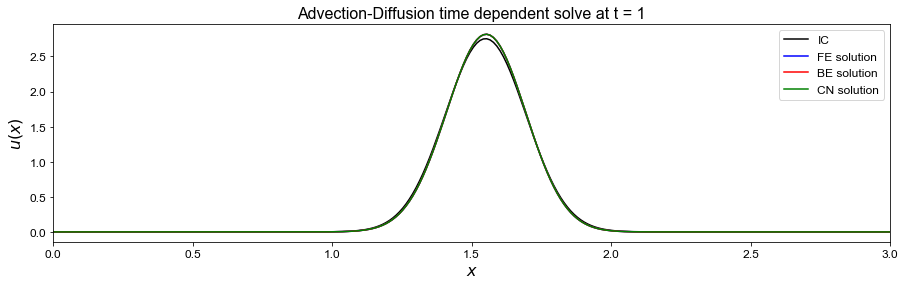

In [210]:

fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$u(x)$', fontsize=16)
ax1.set_title('Advection-Diffusion time dependent solve at t = 1', fontsize=16)
ax1.plot(x_nodes, u_ic_f, 'k-', label='IC')
ax1.plot(x_nodes, u_all[0], 'b-', label='FE solution')
ax1.plot(x_nodes, u_all[1], 'r-', label='BE solution')
ax1.plot(x_nodes, u_all[2], 'g-', label='CN solution')
ax1.legend(loc='best')
ax1.set_xlim(0.0,3.0);

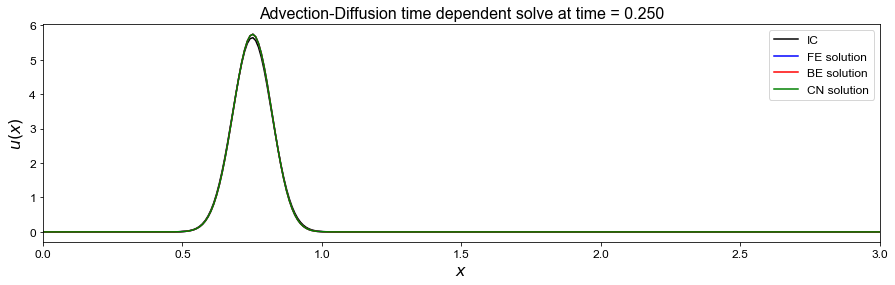

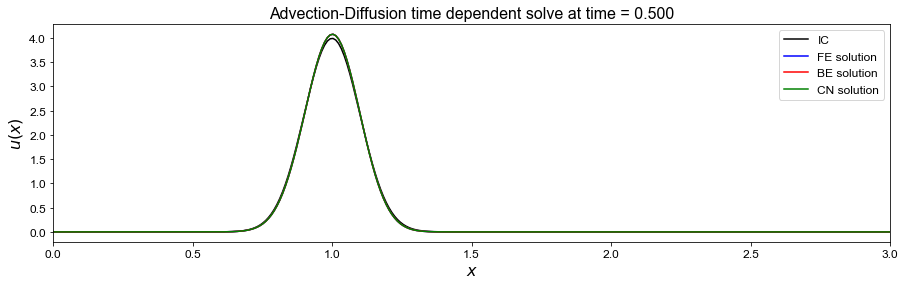

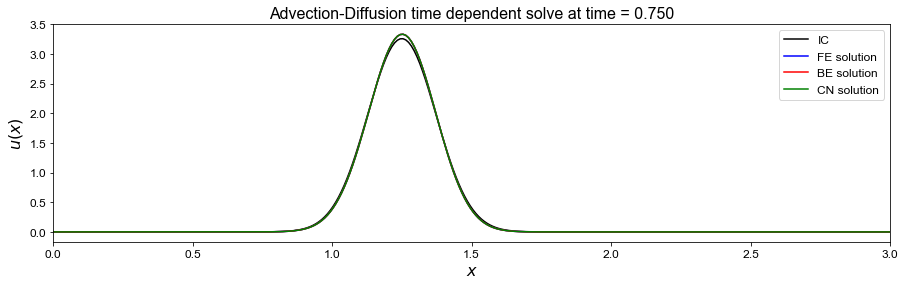

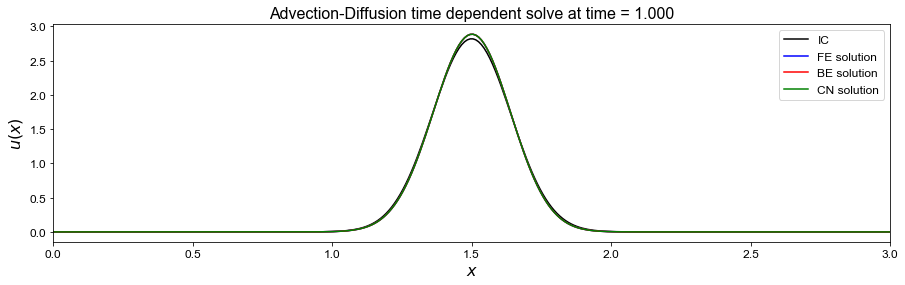

In [208]:
t_iter = 0.25

while t_iter<=1:
    U = 1
    kappa = 1./100.
    L = 3
    dt = 0.001
    t = 0.05
    t_end = t_iter
    theta = [0,0.5,1]
    x0 = 0.5

    # mesh data
    N_nodes_CG = 300
    N_elements_CG = N_nodes_CG - 1

    # define some numerical parameters
    N_loc = 2
    N_gi = 3

    # generate mesh
    x_nodes, dx = generate_1D_CG_mesh(L, N_elements_CG)
    connectivity_matrix = connectivity(N_loc, N_elements_CG)

    # time stepping
    u_ic = initial_condition(x_nodes,x0,t_start,kappa,U, IC_option=0)
    u_ic_f = initial_condition(x_nodes,x0,t_end,kappa,U, IC_option=0)
    #print('r parameter: ', kappa*dt/(np.min(dx)**2))
    #print('Pe_c: ', U*np.min(dx)/kappa)
    #print('CFL: ', U*dt/np.min(dx))

    # set-up things we need for our discretisation
    # the basis functions defined on our reference element
    phi = shape(N_loc, N_gi)

    # quadrature weights
    weight = quadrature(N_gi)

    # allocate space to store our discretisation matrices
    M = np.zeros((N_nodes_CG, N_nodes_CG))
    K1 = np.zeros((N_nodes_CG, N_nodes_CG))
    K2 = np.zeros((N_nodes_CG, N_nodes_CG))

    # assemble the individual discretisation matrices
    assembly_global(M, K1, K2, N_elements_CG, connectivity_matrix, N_loc, N_gi, weight, phi, dx)

    u_all = []
    for i in range(len(theta)):
        # and combine them into our final matrix system
        A = M + dt*theta[i]*(kappa*K1) + dt*theta[i]*(U*K2)
        RHS_matrix = M - dt*(1-theta[i])*(kappa*K1) - dt*(1-theta[i])*(U*K2)
        #and finally time step
        u_old = np.copy(u_ic)
        while t<t_end:
            b = RHS_matrix @ u_old.T 
            apply_bcs(A, b, 0, 0, bc_option=0) # Homogeneous Neumann boundary conditions
            u = sl.solve(A, b)
            u_old = np.copy(u)
            t += dt
        u_all.append(u)

    fig = plt.figure(figsize=(15, 4))
    ax1 = fig.add_subplot(111)
    ax1.set_xlabel('$x$', fontsize=16)
    ax1.set_ylabel('$u(x)$', fontsize=16)
    ax1.set_title('Advection-Diffusion time dependent solve at time = {0:.3f}'.format(t_iter), fontsize=16)
    ax1.plot(x_nodes, u_ic_f, 'k-', label='IC')
    ax1.plot(x_nodes, u_all[0], 'b-', label='FE solution')
    ax1.plot(x_nodes, u_all[1], 'r-', label='BE solution')
    ax1.plot(x_nodes, u_all[2], 'g-', label='CN solution')
    ax1.legend(loc='best');
    ax1.set_xlim(0.0,3.0)
    t_iter+=0.25

## COnvergence analysis with $\Delta x$

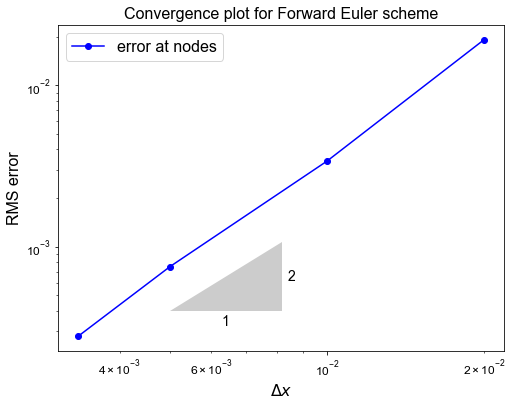

In [214]:
#Ns = [2**p for p in range(6, 12)]
Ns = [50, 100, 200, 300]
errors = np.zeros((2,len(Ns)))

def hat_function(i, x_nodes):
    """ Linear continuous basis function at node i.
    Returns a function for later use in quadrature rules.
    """
    assert(i>=0 and i<=len(x_nodes)-1)
    dx = np.diff(x_nodes)
    if i==0:
        hat = lambda x: np.select([ x<=x_nodes[i+1] ], [ (x_nodes[i+1] - x)/dx[i] ] ,0.0)
    elif i==len(x_nodes)-1:
        hat = lambda x: np.select([ x>=x_nodes[i-1] ], [ (x - x_nodes[i-1])/dx[i-1] ] ,0.0)
    else:
        hat = lambda x: np.select(
                [ np.all([[x>=x_nodes[i-1]],[x<=x_nodes[i]]], axis=0)[0],  
                  np.all([[x>=x_nodes[i]],[x<=x_nodes[i+1]]], axis=0)[0]] ,
                [ (x-x_nodes[i-1])/dx[i-1], (x_nodes[i+1]-x)/dx[i] ] ,0.0)
    return hat

def pwlinear(x_nodes, y_nodes, x):
    """Function to return f_h(x) at locations given in x, 
    with top hat functions on a mesh given by x_nodes, and
    corresponding weights given in y_nodes.
    """
    val = np.zeros_like(x)
    # loop over x values
    for i in range(len(x)):
        # which mesh node is directly to the left of x[i] ?
        node = np.where( x[i] >= x_nodes )[0][-1]
        # because of the greather than or equals above, deal with problem of hitting last node
        node = np.minimum(len(x_nodes)-2,node)
        # add together the contributions from the two hat functions at this x location
        phi_node = hat_function(node, x_nodes)
        phi_node_plus_1 = hat_function(node+1, x_nodes)
        val[i] = y_nodes[node]*phi_node(x[i]) + y_nodes[node+1]*phi_node_plus_1(x[i])
    return val

for i, N in enumerate(Ns):
    U = 1
    kappa = 1./100.
    L = 3
    dt = 0.00001
    t = 0.05
    t_end = t_start + 1
    theta = 0 # forward Euler
    x0 = 0.5

    # mesh data
    N_nodes_CG = N
    N_elements_CG = N_nodes_CG - 1

    # define some numerical parameters
    N_loc = 2
    N_gi = 3

    # generate mesh
    x_nodes, dx = generate_1D_CG_mesh(L, N_elements_CG)
    connectivity_matrix = connectivity(N_loc, N_elements_CG)

    # time stepping
    u_ic = initial_condition(x_nodes,x0,t_start,kappa,U, IC_option=0)
    u_ic_f = initial_condition(x_nodes,x0,t_end,kappa,U, IC_option=0)

    #print('r parameter: ', kappa*dt/(np.min(dx)**2))
    #print('Pe_c: ', U*np.min(dx)/kappa)
    #print('CFL: ', U*dt/np.min(dx))

    # set-up things we need for our discretisation
    # the basis functions defined on our reference element
    phi = shape(N_loc, N_gi)

    # quadrature weights
    weight = quadrature(N_gi)

    # allocate space to store our discretisation matrices
    M = np.zeros((N_nodes_CG, N_nodes_CG))
    K1 = np.zeros((N_nodes_CG, N_nodes_CG))
    K2 = np.zeros((N_nodes_CG, N_nodes_CG))

    # assemble the individual discretisation matrices
    assembly_global(M, K1, K2, N_elements_CG, connectivity_matrix, N_loc, N_gi, weight, phi, dx)

    # and combine them into our final matrix system
    A = M + dt*theta*(kappa*K1) + dt*theta*(U*K2)
    RHS_matrix = M - dt*(1-theta)*(kappa*K1) - dt*(1-theta)*(U*K2)

    #and finally time step
    u_old = np.copy(u_ic)
    while t<t_end:
        b = RHS_matrix @ u_old.T 
        apply_bcs(A, b, 0, 0, bc_option=0)
        u = sl.solve(A, b)
        u_old = np.copy(u)
        t += dt    
    # RMS error of the nodal errors - cf. comments in main lecture text
    errors[0,i] = sl.norm(u - u_ic_f) / np.sqrt(len(u)) 
    # now let's do the RMS on a fine mesh to approximate the L2 norm
    x_fine = np.linspace(x_nodes[0],x_nodes[-1],1000)
    ##u_ic_k = initial_condition(x_fine,x0,t_end,kappa,U, IC_option=0)
    #errors[1,i] = sl.norm(pwlinear(x_nodes, u, x_fine) - u_exact(x_fine,x0,t_end,kappa,U)) \
                        #/ np.sqrt(len(x_fine))


fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$\Delta x$', fontsize=16)
ax1.set_ylabel('RMS error', fontsize=16)
ax1.set_title('Convergence plot for Forward Euler scheme', fontsize=16)
ax1.loglog(1./np.array(Ns), errors[0,:], 'bo-', label='error at nodes')
#ax1.loglog(1./np.array(Ns), errors[1,:], 'ko-', label='error across elements')
ax1.legend(loc='best', fontsize=16)
annotation.slope_marker((5e-3, 4e-4), (2, 1), ax=ax1,
                        size_frac=0.25, pad_frac=0.05, text_kwargs = dict(fontsize = 14))    


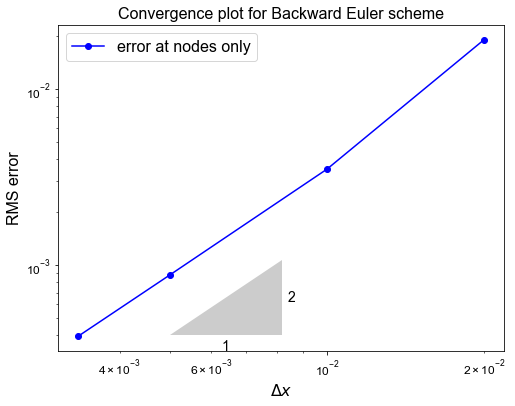

In [216]:
#Ns = [2**p for p in range(6, 12)]
Ns = [50, 100, 200, 300]
errors = np.zeros((2,len(Ns)))

for i, N in enumerate(Ns):
    U = 1
    kappa = 1./100.
    L = 3
    dt = 0.00001
    t = 0.05
    t_end = t_start + 1
    theta = 0.5 # backward Euler
    x0 = 0.5

    # mesh data
    N_nodes_CG = N
    N_elements_CG = N_nodes_CG - 1

    # define some numerical parameters
    N_loc = 2
    N_gi = 3

    # generate mesh
    x_nodes, dx = generate_1D_CG_mesh(L, N_elements_CG)
    connectivity_matrix = connectivity(N_loc, N_elements_CG)

    # time stepping
    u_ic = initial_condition(x_nodes,x0,t_start,kappa,U, IC_option=0)
    u_ic_f = initial_condition(x_nodes,x0,t_end,kappa,U, IC_option=0)

    #print('r parameter: ', kappa*dt/(np.min(dx)**2))
    #print('Pe_c: ', U*np.min(dx)/kappa)
    #print('CFL: ', U*dt/np.min(dx))

    # set-up things we need for our discretisation
    # the basis functions defined on our reference element
    phi = shape(N_loc, N_gi)

    # quadrature weights
    weight = quadrature(N_gi)

    # allocate space to store our discretisation matrices
    M = np.zeros((N_nodes_CG, N_nodes_CG))
    K1 = np.zeros((N_nodes_CG, N_nodes_CG))
    K2 = np.zeros((N_nodes_CG, N_nodes_CG))

    # assemble the individual discretisation matrices
    assembly_global(M, K1, K2, N_elements_CG, connectivity_matrix, N_loc, N_gi, weight, phi, dx)

    # and combine them into our final matrix system
    A = M + dt*theta*(kappa*K1) + dt*theta*(U*K2)
    RHS_matrix = M - dt*(1-theta)*(kappa*K1) - dt*(1-theta)*(U*K2)

    #and finally time step
    u_old = np.copy(u_ic)
    while t<t_end:
        b = RHS_matrix @ u_old.T 
        apply_bcs(A, b, 0, 0, bc_option=0)
        u = sl.solve(A, b)
        u_old = np.copy(u)
        t += dt    
    # RMS error of the nodal errors - cf. comments in main lecture text
    errors[0,i] = sl.norm(u - u_ic_f) / np.sqrt(len(u)) 
    #print(errors[0,i])
    #print(u)
    #print(u_exact(x_nodes,x0,t_end,kappa,U))
    # now let's do the RMS on a fine mesh to approximate the L2 norm
    x_fine = np.linspace(x_nodes[0],x_nodes[-1],1000)
    ##u_ic_k = initial_condition(x_fine,x0,t_end,kappa,U, IC_option=0)
    #errors[1,i] = sl.norm(pwlinear(x_nodes, u, x_fine) - u_exact(x_fine,x0,t_end,kappa,U)) \
                        #/ np.sqrt(len(x_fine))


fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$\Delta x$', fontsize=16)
ax1.set_ylabel('RMS error', fontsize=16)
ax1.set_title('Convergence plot for Backward Euler scheme', fontsize=16)
ax1.loglog(1./np.array(Ns), errors[0,:], 'bo-', label='error at nodes only')
#ax1.loglog(1./np.array(Ns), errors[1,:], 'ko-', label='error across elements')
ax1.legend(loc='best', fontsize=16)
annotation.slope_marker((5e-3, 4e-4), (2, 1), ax=ax1,
                        size_frac=0.25, pad_frac=0.05, text_kwargs = dict(fontsize = 14))    


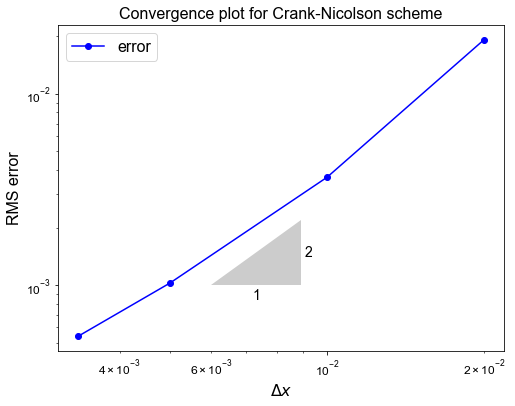

In [213]:
#Ns = [2**p for p in range(6, 12)]
Ns = [50, 100, 200, 300]
errors = np.zeros((2,len(Ns)))

for i, N in enumerate(Ns):
    U = 1
    kappa = 1./100.
    L = 3
    dt = 0.00001
    t = 0.05
    t_end = t_start + 1
    theta = 1
    x0 = 0.5

    # mesh data
    N_nodes_CG = N
    N_elements_CG = N_nodes_CG - 1

    # define some numerical parameters
    N_loc = 2
    N_gi = 3

    # generate mesh
    x_nodes, dx = generate_1D_CG_mesh(L, N_elements_CG)
    connectivity_matrix = connectivity(N_loc, N_elements_CG)

    # time stepping
    u_ic = initial_condition(x_nodes,x0,t_start,kappa,U, IC_option=0)
    u_ic_f = initial_condition(x_nodes,x0,t_end,kappa,U, IC_option=0)

    #print('r parameter: ', kappa*dt/(np.min(dx)**2))
    #print('Pe_c: ', U*np.min(dx)/kappa)
    #print('CFL: ', U*dt/np.min(dx))

    # set-up things we need for our discretisation
    # the basis functions defined on our reference element
    phi = shape(N_loc, N_gi)

    # quadrature weights
    weight = quadrature(N_gi)

    # allocate space to store our discretisation matrices
    M = np.zeros((N_nodes_CG, N_nodes_CG))
    K1 = np.zeros((N_nodes_CG, N_nodes_CG))
    K2 = np.zeros((N_nodes_CG, N_nodes_CG))

    # assemble the individual discretisation matrices
    assembly_global(M, K1, K2, N_elements_CG, connectivity_matrix, N_loc, N_gi, weight, phi, dx)

    # and combine them into our final matrix system
    A = M + dt*theta*(kappa*K1) + dt*theta*(U*K2)
    RHS_matrix = M - dt*(1-theta)*(kappa*K1) - dt*(1-theta)*(U*K2)

    #and finally time step
    u_old = np.copy(u_ic)
    while t<t_end:
        b = RHS_matrix @ u_old.T 
        apply_bcs(A, b, 0, 0, bc_option=0)
        u = sl.solve(A, b)
        u_old = np.copy(u)
        t += dt    
    # RMS error of the nodal errors - cf. comments in main lecture text
    errors[0,i] = sl.norm(u - u_ic_f) / np.sqrt(len(u)) 
    # now let's do the RMS on a fine mesh to approximate the L2 norm
    x_fine = np.linspace(x_nodes[0],x_nodes[-1],1000)
    ##u_ic_k = initial_condition(x_fine,x0,t_end,kappa,U, IC_option=0)
    #errors[1,i] = sl.norm(pwlinear(x_nodes, u, x_fine) - u_exact(x_fine,x0,t_end,kappa,U)) \
                        #/ np.sqrt(len(x_fine))


fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$\Delta x$', fontsize=16)
ax1.set_ylabel('RMS error', fontsize=16)
ax1.set_title('Convergence plot for Crank-Nicolson scheme', fontsize=16)
ax1.loglog(1./np.array(Ns), errors[0,:], 'bo-', label='error')
#ax1.loglog(1./np.array(Ns), errors[1,:], 'ko-', label='error across elements')
ax1.legend(loc='best', fontsize=16)
annotation.slope_marker((6e-3, 1e-3), (2, 1), ax=ax1,
                        size_frac=0.2, pad_frac=0.05, text_kwargs = dict(fontsize = 14))    


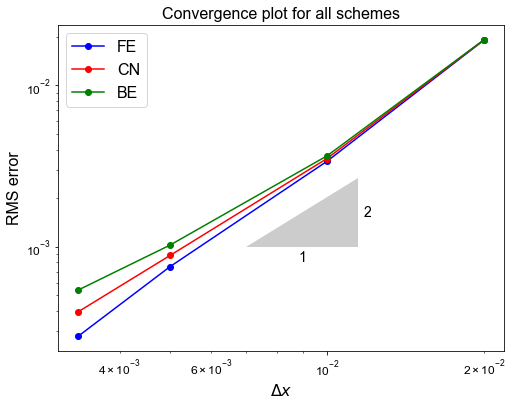

In [222]:
teta = 0.
Ns = [50, 100, 200, 300]
error_all = []
#print(errors)
while teta<=1:
    errors = []
    for i, N in enumerate(Ns):
        U = 1
        kappa = 1./100.
        L = 3
        dt = 0.00001
        t_start = 0.05
        t = 0.05
        t_end = t_start + 1
        theta = teta
        x0 = 0.5

        # mesh data
        N_nodes_CG = N
        N_elements_CG = N_nodes_CG - 1

        # define some numerical parameters
        N_loc = 2
        N_gi = 3

        # generate mesh
        x_nodes, dx = generate_1D_CG_mesh(L, N_elements_CG)
        connectivity_matrix = connectivity(N_loc, N_elements_CG)

        # time stepping
        u_ic = initial_condition(x_nodes,x0,t_start,kappa,U, IC_option=0)
        u_ic_f = initial_condition(x_nodes,x0,t_end,kappa,U, IC_option=0)
        #print('r parameter: ', kappa*dt/(np.min(dx)**2))
        #print('Pe_c: ', U*np.min(dx)/kappa)
        #print('CFL: ', U*dt/np.min(dx))

        # set-up things we need for our discretisation
        # the basis functions defined on our reference element
        phi = shape(N_loc, N_gi)

        # quadrature weights
        weight = quadrature(N_gi)

        # allocate space to store our discretisation matrices
        M = np.zeros((N_nodes_CG, N_nodes_CG))
        K1 = np.zeros((N_nodes_CG, N_nodes_CG))
        K2 = np.zeros((N_nodes_CG, N_nodes_CG))

        # assemble the individual discretisation matrices
        assembly_global(M, K1, K2, N_elements_CG, connectivity_matrix, N_loc, N_gi, weight, phi, dx)

       

            # and combine them into our final matrix system
        A = M + dt*theta*(kappa*K1) + dt*theta*(U*K2)
        RHS_matrix = M - dt*(1-theta)*(kappa*K1) - dt*(1-theta)*(U*K2)
            #and finally time step
        u_old = np.copy(u_ic)
        while t<t_end:
            b = RHS_matrix @ u_old.T 
            apply_bcs(A, b, 0, 0, bc_option=0) # Homogeneous Neumann boundary conditions
            u = sl.solve(A, b)
            u_old = np.copy(u)
            t += dt
        errors.append(sl.norm(u - u_ic_f) / np.sqrt(len(u)))
        #print(errors[0,i])
    error_all.append(errors)  
            
    teta+=0.5
#print(errors[0,:])
#print(errors[,:])
#print(errors[2,:])
#print(errors)
#print(error_all)
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$\Delta x$', fontsize=16)
ax1.set_ylabel('RMS error', fontsize=16)
ax1.set_title('Convergence plot for all schemes', fontsize=16)
ax1.loglog(1./np.array(Ns), error_all[0], 'bo-', label='FE')
ax1.loglog(1./np.array(Ns), error_all[1], 'ro-', label='CN')
ax1.loglog(1./np.array(Ns), error_all[2], 'go-', label='BE')
#ax1.loglog(1./np.array(Ns), errors[1,:], 'ko-', label='error across elements')





ax1.legend(loc='best', fontsize=16)
annotation.slope_marker((7e-3, 1e-3), (2, 1), ax=ax1,
                        size_frac=0.25, pad_frac=0.05, text_kwargs = dict(fontsize = 14))    


## Convergence analysis with $\Delta t$

[0.23772403 0.09768137 0.01444321 0.00567749]


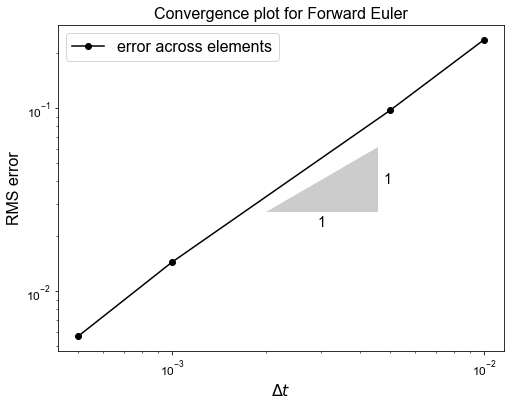

In [195]:
dt_iter = [1e-2, 5e-3, 1e-3, 5e-4]

errors = np.zeros((2,len(dt_iter)))

for i, k in enumerate(dt_iter):
    U = 1
    kappa = 1./100.
    L = 3
    dt = k
    t = 0.05
    t_end = t_start + 1
    theta = 0. # Forward Euler
    x0 = 0.5

    # mesh data
    N_nodes_CG = 120
    N_elements_CG = N_nodes_CG - 1

    # define some numerical parameters
    N_loc = 2
    N_gi = 3

    # generate mesh
    x_nodes, dx = generate_1D_CG_mesh(L, N_elements_CG)
    connectivity_matrix = connectivity(N_loc, N_elements_CG)

    # time stepping
    u_ic = initial_condition(x_nodes,x0,t_start,kappa,U, IC_option=0)
    u_ic_f = initial_condition(x_nodes,x0,t_end,kappa,U, IC_option=0)

    #print('r parameter: ', kappa*dt/(np.min(dx)**2))
    #print('Pe_c: ', U*np.min(dx)/kappa)
    #print('CFL: ', U*dt/np.min(dx))

    # set-up things we need for our discretisation
    # the basis functions defined on our reference element
    phi = shape(N_loc, N_gi)

    # quadrature weights
    weight = quadrature(N_gi)

    # allocate space to store our discretisation matrices
    M = np.zeros((N_nodes_CG, N_nodes_CG))
    K1 = np.zeros((N_nodes_CG, N_nodes_CG))
    K2 = np.zeros((N_nodes_CG, N_nodes_CG))

    # assemble the individual discretisation matrices
    assembly_global(M, K1, K2, N_elements_CG, connectivity_matrix, N_loc, N_gi, weight, phi, dx)

    # and combine them into our final matrix system
    A = M + dt*theta*(kappa*K1) + dt*theta*(U*K2)
    RHS_matrix = M - dt*(1-theta)*(kappa*K1) - dt*(1-theta)*(U*K2)

    #and finally time step
    u_old = np.copy(u_ic)
    while t<t_end:
        b = RHS_matrix @ u_old.T 
        apply_bcs(A, b, 0, 0, bc_option=0)
        u = sl.solve(A, b)
        u_old = np.copy(u)
        t += dt    
    # RMS error of the nodal errors - cf. comments in main lecture text
    #errors[0,i] = sl.norm(u - u_exact(x_nodes,x0,0.05,kappa,U)) / np.sqrt(len(u)) 
    # now let's do the RMS on a fine mesh to approximate the L2 norm
    x_fine = np.linspace(x_nodes[0],x_nodes[-1],1000)
    errors[1,i] = sl.norm(pwlinear(x_nodes, u, x_fine) - u_exact(x_fine,x0,t_end,kappa,U)) \
                        / np.sqrt(len(x_fine))

print(errors[1,:])
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$\Delta t$', fontsize=16)
ax1.set_ylabel('RMS error', fontsize=16)
ax1.set_title('Convergence plot for Forward Euler', fontsize=16)
#ax1.loglog(1./np.array(Ns), errors[0,:], 'bo-', label='error at nodes only')
ax1.loglog(dt_iter, errors[1,:], 'ko-', label='error across elements')
ax1.legend(loc='best', fontsize=16)
annotation.slope_marker((2e-3, 2.7e-2), (1, 1), ax=ax1,
                        size_frac=0.25, pad_frac=0.05, text_kwargs = dict(fontsize = 14))    


[0.01912129 0.0039493  0.00200778 0.00050751]


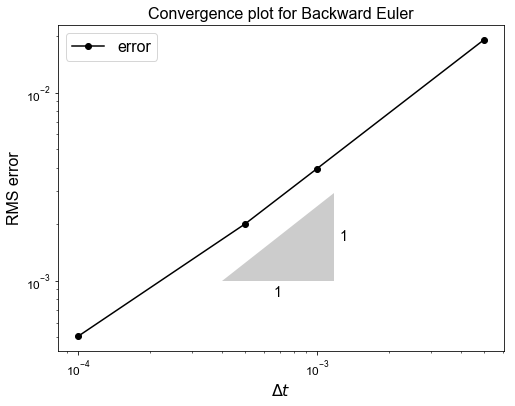

In [196]:
dt_iter = [5e-3, 1e-3, 5e-4, 1e-4]
errors = np.zeros((2,len(dt_iter)))

for i, k in enumerate(dt_iter):
    U = 1
    kappa = 1./100.
    L = 3
    dt = k
    t = 0.05
    t_end = t_start + 1
    theta = 0.5 # Backward Euler
    x0 = 0.5

    # mesh data
    N_nodes_CG = 450
    N_elements_CG = N_nodes_CG - 1

    # define some numerical parameters
    N_loc = 2
    N_gi = 3

    # generate mesh
    x_nodes, dx = generate_1D_CG_mesh(L, N_elements_CG)
    connectivity_matrix = connectivity(N_loc, N_elements_CG)

    # time stepping
    u_ic = initial_condition(x_nodes,x0,t_start,kappa,U, IC_option=0)
    u_ic_f = initial_condition(x_nodes,x0,t_end,kappa,U, IC_option=0)

    #print('r parameter: ', kappa*dt/(np.min(dx)**2))
    #print('Pe_c: ', U*np.min(dx)/kappa)
    #print('CFL: ', U*dt/np.min(dx))

    # set-up things we need for our discretisation
    # the basis functions defined on our reference element
    phi = shape(N_loc, N_gi)

    # quadrature weights
    weight = quadrature(N_gi)

    # allocate space to store our discretisation matrices
    M = np.zeros((N_nodes_CG, N_nodes_CG))
    K1 = np.zeros((N_nodes_CG, N_nodes_CG))
    K2 = np.zeros((N_nodes_CG, N_nodes_CG))

    # assemble the individual discretisation matrices
    assembly_global(M, K1, K2, N_elements_CG, connectivity_matrix, N_loc, N_gi, weight, phi, dx)

    # and combine them into our final matrix system
    A = M + dt*theta*(kappa*K1) + dt*theta*(U*K2)
    RHS_matrix = M - dt*(1-theta)*(kappa*K1) - dt*(1-theta)*(U*K2)

    #and finally time step
    u_old = np.copy(u_ic)
    while t<t_end:
        b = RHS_matrix @ u_old.T 
        apply_bcs(A, b, 0, 0, bc_option=0)
        u = sl.solve(A, b)
        u_old = np.copy(u)
        t += dt    
    # RMS error of the nodal errors - cf. comments in main lecture text
    #errors[0,i] = sl.norm(u - u_exact(x_nodes,x0,0.05,kappa,U)) / np.sqrt(len(u)) 
    # now let's do the RMS on a fine mesh to approximate the L2 norm
    x_fine = np.linspace(x_nodes[0],x_nodes[-1],1000)
    errors[1,i] = sl.norm(pwlinear(x_nodes, u, x_fine) - u_exact(x_fine,x0,t_end,kappa,U)) \
                        / np.sqrt(len(x_fine))

print(errors[1,:])
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$\Delta t$', fontsize=16)
ax1.set_ylabel('RMS error', fontsize=16)
ax1.set_title('Convergence plot for Backward Euler', fontsize=16)
#ax1.loglog(1./np.array(Ns), errors[0,:], 'bo-', label='error at nodes only')
ax1.loglog(dt_iter, errors[1,:], 'ko-', label='error')
ax1.legend(loc='best', fontsize=16)
annotation.slope_marker((4e-4, 1e-3), (1, 1), ax=ax1,
                        size_frac=0.25, pad_frac=0.05, text_kwargs = dict(fontsize = 14))  

[0.07384554 0.01674383 0.00866516 0.00202992]


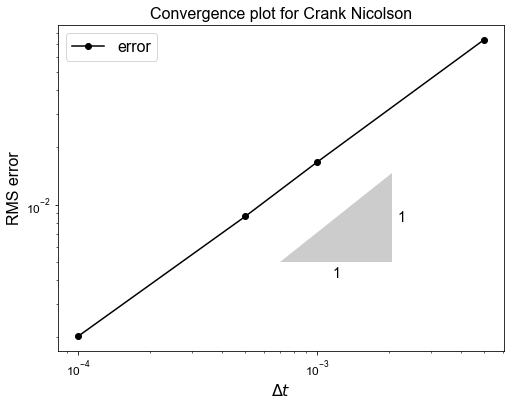

In [207]:
dt_iter = [5e-3, 1e-3, 5e-4, 1e-4]
#dt_iter = [1e-3, 5e-4, 1e-4]
errors = np.zeros((2,len(dt_iter)))

for i, k in enumerate(dt_iter):
    U = 1
    kappa = 1./100.
    L = 3
    dt = k
    t = 0.05
    t_end = t_start + 1
    theta = 1 # crank-Nicolson
    x0 = 0.5

    # mesh data
    N_nodes_CG = 400
    N_elements_CG = N_nodes_CG - 1

    # define some numerical parameters
    N_loc = 2
    N_gi = 3

    # generate mesh
    x_nodes, dx = generate_1D_CG_mesh(L, N_elements_CG)
    connectivity_matrix = connectivity(N_loc, N_elements_CG)

    # time stepping
    u_ic = initial_condition(x_nodes,x0,t_start,kappa,U, IC_option=0)
    u_ic_f = initial_condition(x_nodes,x0,t_end,kappa,U, IC_option=0)

    #print('r parameter: ', kappa*dt/(np.min(dx)**2))
    #print('Pe_c: ', U*np.min(dx)/kappa)
    #print('CFL: ', U*dt/np.min(dx))

    # set-up things we need for our discretisation
    # the basis functions defined on our reference element
    phi = shape(N_loc, N_gi)

    # quadrature weights
    weight = quadrature(N_gi)

    # allocate space to store our discretisation matrices
    M = np.zeros((N_nodes_CG, N_nodes_CG))
    K1 = np.zeros((N_nodes_CG, N_nodes_CG))
    K2 = np.zeros((N_nodes_CG, N_nodes_CG))

    # assemble the individual discretisation matrices
    assembly_global(M, K1, K2, N_elements_CG, connectivity_matrix, N_loc, N_gi, weight, phi, dx)

    # and combine them into our final matrix system
    A = M + dt*theta*(kappa*K1) + dt*theta*(U*K2)
    RHS_matrix = M - dt*(1-theta)*(kappa*K1) - dt*(1-theta)*(U*K2)

    #and finally time step
    u_old = np.copy(u_ic)
    while t<t_end:
        b = RHS_matrix @ u_old.T 
        apply_bcs(A, b, 0, 0, bc_option=0)
        u = sl.solve(A, b)
        u_old = np.copy(u)
        t += dt    
    # RMS error of the nodal errors - cf. comments in main lecture text
    #errors[0,i] = sl.norm(u - u_exact(x_nodes,x0,0.05,kappa,U)) / np.sqrt(len(u)) 
    # now let's do the RMS on a fine mesh to approximate the L2 norm
    x_fine = np.linspace(x_nodes[0],x_nodes[-1],1000)
    errors[1,i] = sl.norm(pwlinear(x_nodes, u, x_fine) - u_exact(x_fine,x0,t_end,kappa,U)) \
                        / np.sqrt(len(x_fine))

print(errors[1,:])
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$\Delta t$', fontsize=16)
ax1.set_ylabel('RMS error', fontsize=16)
ax1.set_title('Convergence plot for Crank Nicolson', fontsize=16)
#ax1.loglog(1./np.array(Ns), errors[0,:], 'bo-', label='error at nodes only')
ax1.loglog(dt_iter, errors[1,:], 'ko-', label='error')
ax1.legend(loc='best', fontsize=16)
annotation.slope_marker((7e-4, 5e-3), (1, 1), ax=ax1,
                        size_frac=0.25, pad_frac=0.05, text_kwargs = dict(fontsize = 14))  

## COOMENTS

1. The convergence plots in terms of varying $\Delta x$, show a convergence order of 2 for all three schemes. This is the expected order, confirming the schemes are central in space.



2. The convergence plots in terms of varying $\Delta t$ show a convegence order of 1 for all the shemes. This is the expected order for both Forward and Backward Euler schemes, however, the Crank-Nicolson schem ought to be 2. I suspect the conditions (e.g initial condition) at which we are integrating the problem contribute to why the expected order of convergence was not gotten for crank Nicolson.



3. The convergence plots for the schemes were created separately to preserve stability of the schemes for the conditions chosen for convergence, most especially the dt.

## Q3: 2D MESH OPTIMISATION

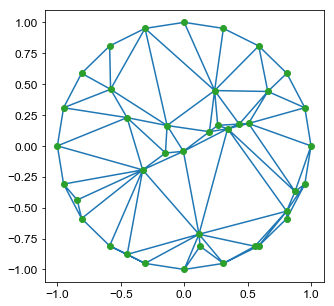

In [223]:
%precision 6
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as si
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spla
# the following allows us to plot triangles indicating convergence order
from mpltools import annotation
# as we're in 2D we will be doing some 3D plotting
from mpl_toolkits.mplot3d import Axes3D
# and using some colormaps
from matplotlib import cm
from pprint import pprint

# some default font sizes for plots
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Dejavu Sans']

points = np.array([[-5.80648777e-01,  4.58163020e-01],
       [-4.49366978e-01, -8.78260592e-01],
       [ 1.25344404e-01, -8.11594100e-01],
       [ 6.59107579e-01,  4.40484354e-01],
       [-4.50759558e-01,  2.28830048e-01],
       [ 2.39877465e-01,  4.47880691e-01],
       [ 5.57255517e-01, -8.12278273e-01],
       [ 1.16512866e-01, -7.15055733e-01],
       [ 8.74019766e-01, -3.69078360e-01],
       [ 8.07618256e-01, -5.28387559e-01],
       [-1.35044590e-01,  1.65036839e-01],
       [ 2.64544176e-01,  1.66414371e-01],
       [ 4.33723660e-01,  1.76408613e-01],
       [ 5.07178633e-01,  1.81359072e-01],
       [-6.36539072e-03, -4.40344606e-02],
       [-3.27218295e-01, -1.94144945e-01],
       [ 1.98845151e-01,  1.14897057e-01],
       [ 3.42407131e-01,  1.38783108e-01],
       [-1.47793003e-01, -5.74951448e-02],
       [-8.43598091e-01, -4.37604895e-01],
       [ 9.51056516e-01,  3.09016994e-01],
       [ 8.09016994e-01,  5.87785252e-01],
       [ 5.87785252e-01,  8.09016994e-01],
       [ 3.09016994e-01,  9.51056516e-01],
       [ 6.12323400e-17,  1.00000000e+00],
       [-3.09016994e-01,  9.51056516e-01],
       [-5.87785252e-01,  8.09016994e-01],
       [-8.09016994e-01,  5.87785252e-01],
       [-9.51056516e-01,  3.09016994e-01],
       [-1.00000000e+00,  1.22464680e-16],
       [-9.51056516e-01, -3.09016994e-01],
       [-8.09016994e-01, -5.87785252e-01],
       [-5.87785252e-01, -8.09016994e-01],
       [-3.09016994e-01, -9.51056516e-01],
       [-1.83697020e-16, -1.00000000e+00],
       [ 3.09016994e-01, -9.51056516e-01],
       [ 5.87785252e-01, -8.09016994e-01],
       [ 8.09016994e-01, -5.87785252e-01],
       [ 9.51056516e-01, -3.09016994e-01],
       [ 1.00000000e+00, -2.44929360e-16]])

from scipy.spatial import Delaunay

tri = Delaunay(points)
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(111)

ax1.triplot(points[:, 0], points[:, 1], tri.simplices)
ax1.plot(points[:, 0], points[:, 1], 'o')

The number of angles is 174
The maximum angle in the mesh is 179.16 in degrees 

The maximum angle in the mesh is 0.41 in degrees 



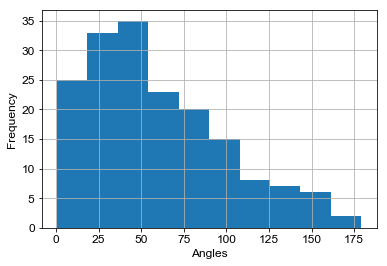

In [224]:
def compute_angles(mesh):
    """
    A function to computes all the angles in a given mesh.
    
    Parameter
    --------
    mesh: an array of lists containing points of a mesh
    
    Returns
    -------
    angles_list: a list of angles of traingles in the given mesh
    
    """
    tri = Delaunay(mesh)
    angles_list = []
    for k in tri.vertices:
        a = points[k] 
        r = np.sqrt((a[0,0]-a[1,0])**2+(a[0,1]-a[1,1])**2)
        s = np.sqrt((a[0,0]-a[2,0])**2+(a[0,1]-a[2,1])**2)
        t = np.sqrt((a[1,0]-a[2,0])**2+(a[1,1]-a[2,1])**2)
        q = np.arccos((r**2 + s**2 - t**2)/(2*r*s))*(180/np.pi)
        angles_list.append(q)
        v = np.arccos((s**2 + t**2 - r**2)/(2*t*s))*(180/np.pi)
        angles_list.append(v)
        w = np.arccos((r**2 + t**2 - s**2)/(2*r*t))*(180/np.pi)
        angles_list.append(w)
    return angles_list

# compute angles for given mesh
a = compute_angles(points)

# print the number, minimum and maximum of angles.
print('The number of angles is', len(a))
print('The maximum angle in the mesh is {0:.2f} in degrees \n'.format(np.max(a)))
print('The maximum angle in the mesh is {0:.2f} in degrees \n'.format(np.min(a)))
# plot histogram of angles
sample = Series(a)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(sample,color='b', alpha=0.5)
ax.set_xlabel('Angles')
ax.set_ylabel('Frequency')
sample.hist()

## Applying Laplacian smoothing

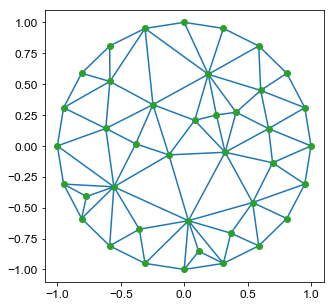

In [225]:

def boundary(mesh):
    """
    A function to determine the number of  boundaries points of a circle given a mesh.
    
        
    Parameter
    --------
    mesh: an array of lists containing points of a mesh
    
    Returns
    -------
    num_bound: the number of boundary points of a circle 
    
    """
    bound = []
    # calculate the distance between points in a mesh
    dis = (mesh[:,0]**2 + mesh[:,1]**2)**0.5
    # assert if the distance is equal to 1, to ensure it's a boundary point
    for d in dis:
        if np.allclose(d,1)==1:
            bound.append(d)
        else:
            pass
    num_bound = len(bound)
    return num_bound

# Determine number of boundary points to ensure locations o mesh
# vertices are preserved in the circular domain.
k = boundary(points)
v0 = tri.vertex_neighbor_vertices[0]
v1 = tri.vertex_neighbor_vertices[1]
# under-relaxation parameter
relax = 0.1
for it in range(100):
    for i in range(points.shape[0]-k):
        average = np.mean(points[v1[v0[i]: v0[i+1]]], axis=0)
        # take a weighted sum of old and proposed locations
        points[i, :] = (1-relax)*points[i, :] + relax*average
        
#new_mesh = points[:,:]
#print(new_mesh)        
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(111)

ax1.triplot(points[:, 0], points[:, 1], tri.simplices)
ax1.plot(points[:, 0], points[:, 1], 'o')

## RESULTS AFTER LAPLACIAN SMOOTHING

The number of angles is 174
The maximum angle in the mesh is 130.98 in degrees 

The maximum angle in the mesh is 23.09 in degrees 



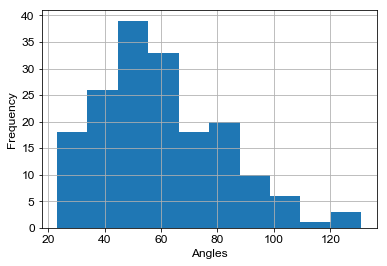

In [226]:
a = compute_angles(points)
print('The number of angles is', len(a))
print('The maximum angle in the mesh is {0:.2f} in degrees \n'.format(np.max(a)))
print('The maximum angle in the mesh is {0:.2f} in degrees \n'.format(np.min(a)))
sample = Series(a)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(sample,color='b', alpha=0.5)
ax.set_xlabel('Angles')
ax.set_ylabel('Frequency')
sample.hist()

## COMMENTS

1. A function was written to calculate the angles of traingles in a given mesh.


2. The minimum and maximum angles were determined prior to Laplacian smoothing as 0.42 and 179.16 in degrees respectively.


3. After Laplacian smoothing, the minimum and maximum angles were 23.09 and 130.98 in degrees respectively.This confirms the mesh quality has improved, so as the angles. The new minimum angle is far higher than zero and the maximum angle is far lower than 180 in degrees. Another confirmation of improved mesh quality is from the histogram, the histogram prior to smoothing is so rightly skewed, whereas after smoothing, the histogram became fairly uniformly distributed.